In [1]:
from datetime import datetime
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import floc

from comscore.data import read_weeks_machines_domains
import prefixLSH

all_panels_cohorts_fpath = '../output/all_panels_cohorts.csv'
T = np.arange(0,0.5,0.01)

## Demographic mappings
race_values = {1:'white', 2:'black', 3:'asian', 5:'other'}
hi_values = {1:'0 to 25k', 2:'25k to 50k', 3:'50k to 100k', 4:'100k +'}
hi_race_values = {
    "1.0, 1.0": "0 to 25k, white",
    "2.0, 1.0": "25k to 50k, white",
    "3.0, 1.0": "50k to 100k, white",
    "4.0, 1.0": "100k +, white",
    
    "1.0, 2.0": "0 to 25k, black",
    "2.0, 2.0": "25k to 50k, black",
    "3.0, 2.0": "50k to 100k, black",
    "4.0, 2.0": "100k +, black",
    
    "1.0, 3.0": "0 to 25k, asian",
    "2.0, 3.0": "25k to 50k, asian",
    "3.0, 3.0": "50k to 100k, asian",
    "4.0, 3.0": "100k +, asian",
    
    "1.0, 5.0": "0 to 25k, other",
    "2.0, 5.0": "25k to 50k, other",
    "3.0, 5.0": "50k to 100k, other",
    "4.0, 5.0": "100k +, other",
}

## Functions

In [2]:
def get_cohort_demo_portions_df(panel_df, demo_col):
    df = panel_df.groupby(
        ['cohort', demo_col]
    ).count()['panel_id'].rename('count').to_frame().reset_index(demo_col)
    df['total'] = panel_df.groupby('cohort').count()['panel_id']
    df['portion'] = df['count']/df['total']
    return df

## 1. read in panel data with cohort IDs

In [3]:
all_panels_df = pd.read_csv(all_panels_cohorts_fpath)
print('read in all panels: %s total rows' % len(all_panels_df))
print('%s panels' % all_panels_df.panel_id.nunique())
all_panels_df.head()

read in all panels: 3302090 total rows
520 panels


,machine_id,week,n_domains,household_income,racial_background,stratify,panel_id,simhash,cohort
0,225477651,1,40,1.0,1.0,"1.0, 1.0",1,1053512748232354,107.0
1,215623532,1,43,1.0,1.0,"1.0, 1.0",1,207270634237270,20.0
2,186655210,1,147,1.0,1.0,"1.0, 1.0",1,155255686110552,14.0
3,224752776,1,45,1.0,1.0,"1.0, 1.0",1,765518950719653,74.0
4,207687017,1,22,1.0,1.0,"1.0, 1.0",1,1087583118580527,110.0


### 1.1 calculate overall prevalences

In [138]:
cohort_demo_portions_df = get_cohort_demo_portions_df(panel_df, demo_col)
demo_fractions = panel_df.dropna().groupby(demo_col)['panel_id'].count() / len(panel_df.dropna())
panel_id = 38
demo_col="racial_background"
t = 0.01

In [135]:
cohort_demo_portions_df.head()

,racial_background,count,total,portion
cohort,,,,
1.0,1.0,36,48,0.750000
1.0,2.0,7,48,0.145833
1.0,3.0,2,48,0.041667
1.0,5.0,3,48,0.062500
2.0,1.0,63,81,0.777778


In [142]:
(cohort_demo_portions_df
 .assign(population_portion = lambda x: x[demo_col].map(demo_fractions))
 .assign(t = lambda x: x.portion - x.population_portion)
 .assign(blocked = lambda x: x.t >= t)
 .reset_index()
 .assign(n_cohorts = lambda x: x.cohort.nunique())
 .groupby(['racial_background'])
 .apply(lambda x: sum(x.blocked) / x.n_cohorts)
 .reset_index()
 [['racial_background', 'n_cohorts']]
 .drop_duplicates()
  .rename(columns={'n_cohorts': 'pct_blocked'})
 .reset_index(drop=True)
 .assign(t=t)
)

,racial_background,pct_blocked,t
0,1.0,0.178218,0.05
1,2.0,0.118812,0.05
2,3.0,0.069307,0.05
3,5.0,0.019802,0.05


In [118]:
panel_df = all_panels_df[all_panels_df.panel_id == panel_id]
from tqdm.notebook import tqdm


def calculate_pct_blocked(panel_df, demo_col, t):
    """demo_col, 'pct_blocked'
    """
    cohort_demo_portions_df = get_cohort_demo_portions_df(panel_df, demo_col)
    demo_fractions = panel_df.dropna().groupby(demo_col)['panel_id'].count() / len(panel_df.dropna())
    return (cohort_demo_portions_df
     .assign(population_portion = lambda x: x[demo_col].map(demo_fractions))
     .assign(t = lambda x: x.portion - x.population_portion)
     .assign(blocked = lambda x: x.t >= t)
     .reset_index()
     .assign(n_cohorts = lambda x: x.cohort.nunique())
     .groupby(['racial_background'])
     .apply(lambda x: sum(x.blocked) / x.n_cohorts)
     .reset_index()
     [['racial_background', 'n_cohorts']]
     .drop_duplicates()
     .rename(columns={'n_cohorts': 'pct_blocked'})
     .reset_index(drop=True)
     .assign(t=t)
    )

def panel_t_closeness(panel_df, demo_col, T=T):
    """calculates t-closeness for a range of t values for a given demographic column and
    panel dataframe.
    returns a dataframe with the following columns
    """
    return pd.concat([calculate_pct_blocked(panel_df, demo_col, t) for t in T])

def all_panels_t_closeness(all_panels_df, demo_col, T=T, panel_ids=None):
    if panel_ids is None:
        panel_ids = all_panels_df.panel_id
    panels = [all_panels_df[all_panels_df.panel_id == panel_id] for panel_id in panel_ids]
    print("Extracted panels. computing t-closenes...")
    t_closeness_dfs = [panel_t_closeness(panel, demo_col, T).assign(panel_id=panel_id) for panel, panel_id in tqdm(zip(panels, panel_ids))]
    return pd.concat(t_closeness_dfs)


In [124]:
panels = np.random.choice(all_panels_df.panel_id, size=100)
tt = all_panels_t_closeness(all_panels_df, demo_col, panel_ids = panels)

Extracted panels. computing t-closenes...


0it [00:00, ?it/s]

### 1.2 Plot curves for each demographic group

- x: t
- y: # or % of cohorts blocked

/Users/dcalacci/.pyenv/versions/3.9.1/envs/floc/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.


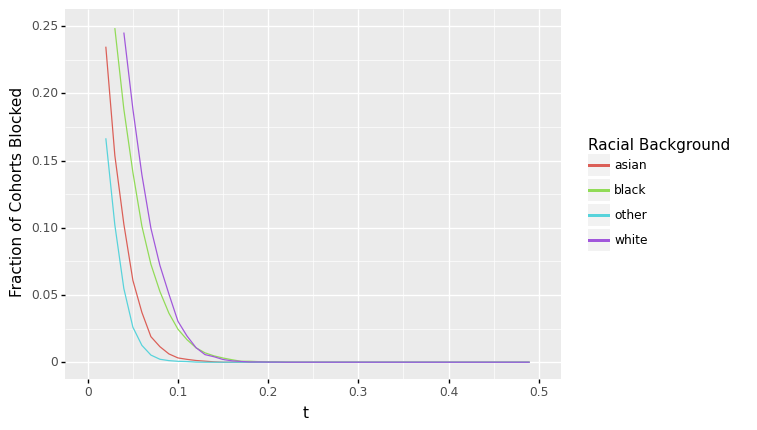

<ggplot: (390191683)>

In [167]:
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_ribbon, geom_line, xlim, labs, scale_y_continuous, ylim
n_cohorts_all = all_panels_df.cohort.nunique()

df = (tt
 .assign(racial_background = lambda x: x.racial_background.map(race_values))
 .groupby(['t', 'racial_background'])
 .agg({'pct_blocked': [np.mean, 
                               lambda x: np.mean(x) + 1.96*np.std(x),
                               lambda x: np.mean(x) - 1.96*np.std(x)]})
 .set_axis(['pct_blocked', 'upper', 'lower'], axis=1, inplace=False)
 .reset_index()
)

(ggplot(df, aes(color='racial_background')) +
# geom_ribbon(aes(x='t', ymin='lower', ymax='upper'), alpha=0.02, linetype='dashed', size=0.3) +
 geom_line(aes(x='t', y='pct_blocked')) +
labs(y="Fraction of Cohorts Blocked",
    x="t",
    color="Racial Background") +
# scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l])+
 ylim(0, 0.25) +
 xlim(0, 0.5)
)

In [39]:
(tt
 [tt.blocked == False]
 .assign(pct_cohorts_blocked = lambda x: (n_cohorts_all-x.n_cohorts)/n_cohorts_all)
)

,racial_background,blocked,n_cohorts,t,panel_id,pct_cohorts_blocked
0,1.0,False,54,0.00,38,0.553719
2,2.0,False,54,0.00,38,0.553719
4,3.0,False,57,0.00,38,0.528926
6,5.0,False,40,0.00,38,0.669421
0,1.0,False,56,0.01,38,0.537190
...,...,...,...,...,...,...
3,5.0,False,88,0.48,39,0.272727
0,1.0,False,99,0.49,39,0.181818
1,2.0,False,99,0.49,39,0.181818
2,3.0,False,97,0.49,39,0.198347


,t,racial_background,pct_blocked,upper,lower
0,0.00,1.0,0.582645,0.639339,0.525950
1,0.00,2.0,0.574380,0.614876,0.533884
2,0.00,3.0,0.549587,0.590083,0.509091
3,0.00,5.0,0.628099,0.709091,0.547107
4,0.01,1.0,0.541322,0.549421,0.533223
...,...,...,...,...,...
195,0.48,5.0,0.297521,0.346116,0.248926
196,0.49,1.0,0.173554,0.189752,0.157355
197,0.49,2.0,0.173554,0.189752,0.157355
198,0.49,3.0,0.190083,0.206281,0.173884


(0.0, 0.5)

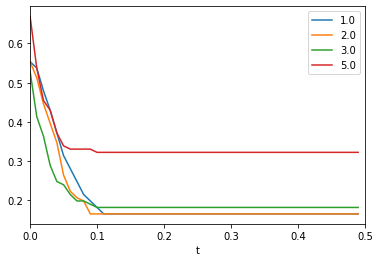

In [20]:
#Plot
n_cohorts_all = all_panels_df.cohort.nunique()
fig = plt.figure()
ax = plt.subplot()
(tt
 [tt.blocked == False]
 .assign(pct_cohorts_blocked = lambda x: (n_cohorts_all-x.n_cohorts)/n_cohorts_all)
 .set_index('t')
 .groupby(demo_col)
 ['pct_cohorts_blocked']
 .plot(legend=True, ax=ax)
)
ax.set_xlim(0,0.5)

---

## Old Code

In [ ]:
def plot_t_closeness(panel_df, demo_col, demo_value_names_dict):
    cohort_demo_portions_df = get_cohort_demo_portions_df(panel_df, demo_col)
    demo_fractions = panel_df.dropna().groupby(demo_col)['panel_id'].count() / len(panel_df.dropna())
    
    for val in demo_value_names_dict:
        print('%s' % demo_value_names_dict[val])
        cohort_demo_mean = cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.mean()
        print('mean fraction %s across cohorts = %0.2f' % (demo_value_names_dict[val], cohort_demo_mean))
        # Google's sensitivity analysis actually looked at avg for sensitive categories
        # across all users rather than across cohorts
        demo_fraction = demo_fractions[val]
        print('fraction %s across all users in cohorts = %0.2f' % (demo_value_names_dict[val], demo_fraction))

        fig,ax = plt.subplots(1,1,figsize=(6,3), dpi=dpi)
        cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.sort_values(ascending=False).plot.bar(ax=ax, label="")

        ax.hlines(y=demo_fraction, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='-', color='black', label='mean')
        if (demo_fraction - t) > 0:
            ax.hlines(y=demo_fraction-t, xmin=0, xmax=len(ax.get_xticks()), 
                      linestyles='--', color='black', label='mean - t=0.1')
        ax.hlines(y=demo_fraction+t, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='--', color='black', label='mean + t=0.1')
        #ax.legend()
        ax.set_xticks([])
        ax.set_xlabel('cohorts')
        ax.set_ylabel('fraction "%s"' % demo_value_names_dict[val])
        plt.show()
    
    return cohort_demo_portions_df

In [ ]:
demo_col='race'

cohort_demo_portions_df = get_cohort_demo_portions_df(panel_df, demo_col)
demo_fractions = panel_df.dropna().groupby(demo_col)['panel_id'].count() / len(panel_df.dropna())

In [ ]:

cohort_demo_portions_df = get_cohort_demo_portions_df(panel_df, demo_col)
demo_fractions = panel_df.dropna().groupby(demo_col)['panel_id'].count() / len(panel_df.dropna())

for val in demo_value_names_dict:
    print('%s' % demo_value_names_dict[val])
    cohort_demo_mean = cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.mean()
    print('mean fraction %s across cohorts = %0.2f' % (demo_value_names_dict[val], cohort_demo_mean))
    # Google's sensitivity analysis actually looked at avg for sensitive categories
    # across all users rather than across cohorts
    demo_fraction = demo_fractions[val]
    print('fraction %s across all users in cohorts = %0.2f' % (demo_value_names_dict[val], demo_fraction))

    fig,ax = plt.subplots(1,1,figsize=(6,3), dpi=dpi)
    cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.sort_values(ascending=False).plot.bar(ax=ax, label="")
    